# Error-tolerant BS-based circuit

In this notebook, we aim to present the BS-based circuit which is an alternative to Mach-Zehnder interferometers usually exploited because it is capable of implementing arbitrary transfer matrices. BS-based circuit seems to be tolerant of manufacturing errors and losses due to its design according to Fldzhyan et al (2020) Optimal design of error-tolerant reprogrammable multiport interferometers. Optics Letters, 45(9):2632–2635

## Introduction 

### Parameters

The variable phase shifts $\phi$ are used to reconfigure the interferometer and have required ranges from 0 to 2π. The variation of the $\phi$ parameter allows us to obtain different transfer matrices $U_{interf}$ each time. These matrices will then be compared to random unitary matrices $U_{target}$ generated by Perceval of the BS-based with the calculation of the fidelity. 

Parameters $\alpha$ describe errors caused by the imbalances of the static BSs due to non-ideal realization. $\alpha$ represents manufacturing errors. Therefore, to analyze the error tolerance of the BS, we vary the $\alpha$ values to explore the different values of associated infidelity. 

We are not looking for fidelity value because for this cricuit, no analytical solution is known to derive phase shifts that maximize the fidelity. [1]
Consequently, the aim of this program is to minimize the infidelity.

## Perceval implementation

### Initialisation

In [1]:
import datetime
import time
import numpy as np
from scipy.optimize import basinhopping
import random
import perceval as pcvl
import perceval.lib.phys as phys
import os
import math
from tqdm.notebook import tqdm_notebook

We define all parameters used in this program : 

In [1]:
N=3
n_try=10
n_iter=3
n_process=8
angle_min=-15
angle_max=30
angle_step=2
n_unitary=300
logfilebs='bsbasednotebook-opt'
logfilemzi='mzibasednotebook-opt'

These parameters might take a long tome to run. To test the program quickly, you can use the following simplified values.

In [2]:
N=3
n_try=2
n_iter=2
n_process=8
angle_min=-15
angle_max=30
angle_step=10
n_unitary=3
logfilebs='bsbasednotebook-opt'
logfilemzi='mzibasednotebook-opt'

## 1- BS-based

### Circuit construction :  BS-based 

We start by describing the circuit as defined by the paper above [1] using `pcvl.Circuit.generic_interferometer()`. The circuit is built with a single static beam-splitter and a variable phase shift. There is also a phase at the beginning of each mode.

In [4]:
bs = pcvl.Circuit.generic_interferometer(N,
                                         lambda idx : phys.BS(theta=pcvl.P("theta_%d"%idx))//(0, phys.PS(phi=np.pi*2*random.random())),
                                         shape="rectangle",
                                         depth = 2*N,
                                         phase_shifter_fun_gen=lambda idx: phys.PS(phi=np.pi*2*random.random()))
pcvl.pdisplay(bs, recursive = True)


### Minimizing infidelity

First, we define a function which calculate the infidelity from the fidelity. The fidelity evaluate the performance of multiport interferometers $F=\frac{\lvert \mathrm{Tr} ({U_{target}}^{\dagger} U_{interf}) \rvert²}{N\mathrm{Tr}({U_{target}}^{\dagger} U_{target})}$. It compares the target matrix $U_{target}$ and the actual unitary matrix $U_{interf}$ realized by the interferometer, where N is the size of the matrices.

In [5]:
def infidelity(c, U_target, params, params_value):
    """
    inputs: 
    *c* type: circuit from pcvl.Circuit()
        role: generic interferometer to optimize 
    *U_target* type: matrix from pcvl.Matrix.random_unitary()
               role: unitary matrix randomly chosen
    *params* type: parameters from c.get_parameters()
             role: get the parameters associated to the circuit c 
    *params_value* type: int
                   role: value of the parameters

    outputs: 
    *infidelity value* type: int
                       role: infidelity value between U and U0
    """
    for idx, p in enumerate(params_value):
        params[idx].set_value(p) #give a value to each params
    U = c.compute_unitary(use_symbolic=False) #
    U_dag = np.transpose(np.conjugate(U))
    f = abs(np.trace(U_dag @ U_target)) ** 2 / (c.m * np.trace(U_dag @ U))
    return 1 - abs(f)

### Basinhopping algorithm

Then, we want to find phis $\phi$ matching $U_{interf}$ by minimizing the infidelity. To do so, we used a numerical optimization algorithm based on the basinhopping algorithm to minimize infidelity $1 - F$. The algorithm was searching for a global minimum of infidelity $1 - F$ over the space of phase-shifts. [1]

In [9]:
def calculate_angle(index_unitary,U_target,alpha):
    """
    inputs:
    *index_unitary* type: int
                    role: index on the number of unitary matrices 
    *U_target* type: matrix from pcvl.Matrix.random_unitary()
               role: unitary matrix randomly chosen
    *alpha* type: int
            role: angle error due to manufacturing 

    outputs:
    *infidelity min* type: int
                     role: min value of infidelity
    """
    start = time.time()
    c = pcvl.Circuit.generic_interferometer(N,
                                            lambda idx: (phys.BS(theta=(45+alpha)/180*np.pi)
                                                            // (0, phys.PS(phi=pcvl.P("phi_m%d" % idx)))),
                                            depth=2*N,
                                            phase_shifter_fun_gen=lambda idx: phys.PS(phi=pcvl.P("phi_r%d" % idx)))
    params = c.get_parameters()     #We get the parameters of the circuit we have just created
    
    infidelities = []

    for _ in range(n_try):          #We do a number of tests
        init_params = np.random.randn(len(params)) 
        res = basinhopping(lambda x: infidelity(c, U_target, params, x), init_params, stepsize=0.1, niter=n_iter) #the algorithm is looking for a global minimum of infidelity
        infidelities.append(res.fun) #fun is the value of the function at the solution
    return min(infidelities)

Based on the `calculate_angle()`function, we get the minimal infidelity value for each angle. Higher `n_iter` is, more the basinhopping algorithm explores the infidelity values.

Now, we have an infidelity value for each angle and a list of those infidelities for the matrix $U_{interf}$ from BS-based circuit compared to the random unitary matrix $U_{target}$.

In [10]:
n_angles = (abs(angle_min)+abs(angle_max))/angle_step

def discovery_unitary(index_unitary):
    """
    inputs:
    *param index_unitary* type: int
                          role: index on the number of unitary matrices
    outputs:
    type: list of int
    role: infidelities for all alpha angles
    """
    np.random.seed(int(10000*time.time()+os.getpid()) & 0xffffffff) #not necessary here, but when we run our program on several cores, this line allows us to generate different unit matrices at the same time.
    U_target = pcvl.Matrix.random_unitary(N)                        #generates the unit random matrix
    l_infidelities = []
    M=angle_min + math.ceil((angle_max-angle_min)/angle_step)*angle_step + 1

    for alpha in tqdm_notebook(range(angle_min,M,angle_step), desc = "Angle progress bar unitary {}".format(index_unitary+1), leave=False):
        l_infidelities.append(calculate_angle(index_unitary, U_target, alpha)) 
    return l_infidelities
    
try:
    os.remove("%s-%d.log" % (logfilebs,N)) #To avoid having data on our file that we don't want, we delete the data from previous runs
except OSError:
    pass

for index_unitary in tqdm_notebook(range(n_unitary), desc = "Unitary progress bar"):
    result = discovery_unitary(index_unitary)
    e = datetime.datetime.now()
    with open("%s-%d.log" % (logfilebs,N), "a") as f:    #we create our file
        f.write(e.strftime("%Y-%m-%d %H:%M:%S")+"\t")    #we add the date and the hour of calculation             
        f.write("\t".join(["%g"%inf for inf in result])) #we add the list of infidelities returned by discovery_unitary()
        f.write("\n")

Unitary progress bar:   0%|          | 0/3 [00:00<?, ?it/s]

Angle progress bar unitary 1:   0%|          | 0/6 [00:00<?, ?it/s]

Angle progress bar unitary 2:   0%|          | 0/6 [00:00<?, ?it/s]

Angle progress bar unitary 3:   0%|          | 0/6 [00:00<?, ?it/s]

### Data process

In this section, we treat the previously collected infidelity values as a function of $\alpha$. What could be better than a graph to illustrate our results?  

This is the data collected : 

Each lign starts with date and hour of collect and then, we have each minimal infidelity per $\alpha$.
We have a lign per unitarian matrix $U_{target}$.

In [ ]:
with open("bsbasednotebook-opt-5.log", "r") as filin:
...     for ligne in filin:
...         print(ligne)

### Graph of the infidelity as a function of $\alpha$ in degree : BS-based

We want to plot the infidelity graph as a function of the alpha angle values. To do this, we compute the average of the infidelities by unitary matrix $U_{target}$. We put this average in a list.

In [ ]:
import numpy as np
L=[]
with open("bsbasednotebook-opt-5.log", "r") as flog:
    for l in flog:
        L.append([float (f) for f in l.strip().split("\t")[1:]])

A=np.asarray(L)
print(A)
print(A.shape)

In [ ]:
Lmin=[]
Lmax=[]
Laverage=[]

for i in range(A.shape[1]):
    Langle = A[:,i]
    Laverage.append(np.average(Langle))
    Langle.sort()
    Lmin.append(np.average(Langle[0:10]))
    Lmax.append(np.average(Langle[-10:]))

print(Laverage)
print(Lmin)
print(Lmax)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#data
x = np.linspace(-15, 35, len(Laverage))

fig, ax = plt.subplots()

ax.fill_between(x, Lmin, Lmax,alpha=.5,linewidth=0)
ax.plot(x,Laverage,linewidth=2)

ax.set(xlim=(-15, 35),ylim=(min(Lmin), max(Lmax)))
ax.set_yscale('log')


plt.plot(x,Laverage,'b')
plt.title('BS-based', fontsize=20)
plt.xlabel('alpha in degree', fontsize=15)
plt.ylabel('infidelity 1-F', fontsize=15)

## 2- MZI-based

### Circuit construction : MZI-based

Now, let's do the same for MZI-based circuit. This circuit is built with composition of beam-splitters. The main difference between the both circuit is the structure. The MZI-based circuit has $m$ building blocks with four components whereas the BS-based circuit has $2*m$ building blocks with two components.

In [ ]:
def mzi(P1,P2):
    mz= (pcvl.Circuit(2, name="mzi")
       .add((0, 1), phys.BS(theta=(45)/180*np.pi))
       .add(0, phys.PS(P1))
       .add((0, 1), phys.BS(theta=(45)/180*np.pi))
       .add(0, phys.PS(P2)))
    return mz

In [ ]:
c = pcvl.Circuit.generic_interferometer(N,
                                        fun_gen=lambda idx: mzi(pcvl.P("phi_m%d" % idx),pcvl.P("phi_n%d" % idx)),
                                        shape="rectangle",
                                        depth=N,
                                        phase_shifter_fun_gen=lambda idx: phys.PS(phi=pcvl.P("phi_r%d" % idx)))
pcvl.pdisplay(c)

### Minimizing infidelity

#### Basinhopping algorithm

In [ ]:
def mzi(P1,P2,alpha):
    mz= (pcvl.Circuit(2, name="mzi")
       .add((0, 1), phys.BS(theta=(45+alpha)/180*np.pi))
       .add(0, phys.PS(P1))
       .add((0, 1), phys.BS(theta=(45+alpha)/180*np.pi))
       .add(0, phys.PS(P2)))
    return mz

In [ ]:
def calculate_angle(index_unitary, U_target, alpha):
    start = time.time()
    c = pcvl.Circuit.generic_interferometer(N,
                                        fun_gen=lambda idx: mzi(pcvl.P("phi_m%d" % idx),pcvl.P("phi_n%d" % idx),alpha),
                                        shape="rectangle",
                                        depth=N,
                                        phase_shifter_fun_gen=lambda idx: phys.PS(phi=pcvl.P("phi_r%d" % idx)))
    params = c.get_parameters()

    # goal is to find phis matching U0 - by minimizing fidelity
    infidelities = []

    for _ in range(n_try):
        init_params = np.random.randn(len(params))
        res = basinhopping(lambda x: infidelity(c, U_target, params, x), init_params, stepsize=0.1, niter=n_iter)
        infidelities.append(res.fun)
    
    return min(infidelities)

In [11]:
n_angles = (abs(angle_min)+abs(angle_max))/angle_step

def discovery_unitary(index_unitary):
    np.random.seed(int(10000*time.time()+os.getpid()) & 0xffffffff)
    U_target = pcvl.Matrix.random_unitary(N)
    l_infidelities = []
    M=angle_min + math.ceil((angle_max-angle_min)/angle_step)*angle_step + 1
    for alpha in tqdm_notebook(range(angle_min,M,angle_step), desc = "Angle progress bar unitary {}".format(index_unitary+1),leave=False):
        l_infidelities.append(calculate_angle(index_unitary, U_target, alpha))
    return l_infidelities

try:
    os.remove("%s-%d.log" % (logfilemzi,N))
except OSError:
    pass

for index_unitary in tqdm_notebook(range(n_unitary), desc = "Unitary progress bar"):
    result = discovery_unitary(index_unitary)
    e = datetime.datetime.now()
    with open("%s-%d.log" % (logfilemzi,N), "a") as f:
        f.write(e.strftime("%Y-%m-%d %H:%M:%S")+"\t")                
        f.write("\t".join(["%g"%inf for inf in result]))
        f.write("\n")

Unitary progress bar:   0%|          | 0/3 [00:00<?, ?it/s]

Angle progress bar unitary 1:   0%|          | 0/6 [00:00<?, ?it/s]

Angle progress bar unitary 2:   0%|          | 0/6 [00:00<?, ?it/s]

Angle progress bar unitary 3:   0%|          | 0/6 [00:00<?, ?it/s]

### Data process

In [ ]:
with open("mzibasednotebook-opt-5.log", "r") as filin:
...     for ligne in filin:
...         print(ligne)

In [ ]:
import numpy as np
L=[]
with open("mzibasednotebook-opt-5.log", "r") as flog:
    for l in flog:
        L.append([float (f) for f in l.strip().split("\t")[1:]])

A=np.asarray(L)
print(A)
print(A.shape)

In [ ]:
Lmin=[]
Lmax=[]
Laverage=[]

for i in range(A.shape[1]):
    Langle = A[:,i]
    Laverage.append(np.average(Langle))
    Langle.sort()
    Lmin.append(np.average(Langle[0:10]))
    Lmax.append(np.average(Langle[-10:]))

print(Laverage)
print(Lmin)
print(Lmax)

### Graph of the infidelity as a function $\alpha$ in degree : MZI-based

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#data
x = np.linspace(-15, 35, len(Laverage))

fig, ax = plt.subplots()

ax.fill_between(x, Lmin, Lmax,alpha=.5,linewidth=0)
ax.plot(x,Laverage,linewidth=2)

ax.set(xlim=(-15, 35),ylim=(min(Lmin), max(Lmax)))
ax.set_yscale('log')


plt.plot(x,Laverage,'r')
plt.title('MZI-based', fontsize=20)
plt.xlabel('alpha in degree', fontsize=15)
plt.ylabel('infidelity 1-F',fontsize=15)


## Our results

We cannot run here the previous program with large matrices, it would be too long. We did it in a qjupyter terminal.
Here are our results:

For matrices of size 5, we obtained this graph below.

![](../_static/img/bs-notebook5.png)
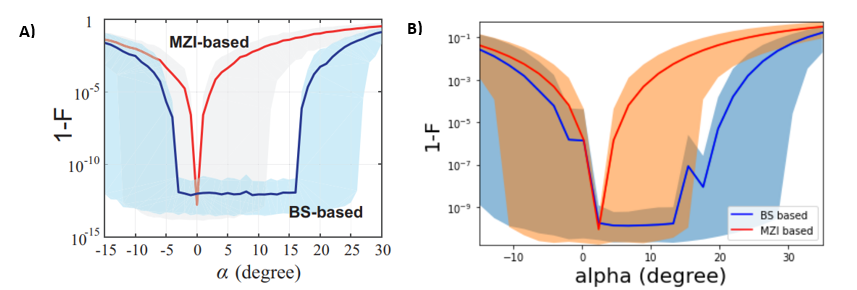

The MZI-based interferometers are equally sensitive to both positive and negative values of α with the acceptable range of errors is of the order of several degrees. For the BS-based interferometers, infidelity behaves radically different: while at α < 0 the performance of the two are comparable, at α > 0 the BS-based interferometers provide perfect fidelity for α as
large as ∼ 20 degrees — several times larger than for the MZI-based interferometers. Therefore, the BS-based circuit is more stable than the MZI-based circuit.

In the article [1], they did their other measurement on matrices of size 10. On our side, we wanted to go further and make our calculations on matrices of size 12. This is a preferred size for Quandela because it is the size of the QPU chip.

![](../_static/img/bs-notebook12.png)

We only made our calculations for the BS-based because we want to analyze the stability of this new circuit. If we could have done both, we would have, but we were restricted by a few things. Indeed, for only one matrix of size 12, the calculation takes about 37 hours. Since in our code, we loop over 300 matrices, we must multiply 300 by 37 to get the total time it would take to complete this calculation. This gives 11,100 hours (~460 days) of calculation in total. 

On top of that, even with 17 matrices, we can see the stability of the BS-based circuit. Indeed, on the previous graph we can see very clearly a plateau taking shape. 

We were thus satisfied with 17 matrices. This graph allows us to see very well that for an alpha angle of 10 degrees, the BS circuit is very stable. There is an insensitivity to errors at this angle.

To conclude, BS-based circuit is a very stable scheme but not universal. MZI-based circuit is universal when it is stable. But as you can see on the graphs, the MZI-based circuit is not stable at all. In practice, it is not common to have $\alpha=0$ so, the MZI-based circuit is not really universal.

Therefore, it is necessary to continue to seek relevant criteria to properly evaluate the interferometer schemes. Indeed, these criteria can only make the laboratory experiments more optimal.

[1] Suren A Fldzhyan, M Yu Saygin, and Sergei P Kulik. Optimal design of error-tolerant reprogrammable multiport interferometers. Optics Letters, 45(9):2632–2635, 2020.